Note: The script uses Berkeley Neural Parser to parse the generated instructions, and visualize the results using Plotly.

Please make sure to install benepar following their documentation [here](https://github.com/nikitakit/self-attentive-parser#installation).

In [50]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
import tqdm
import random

In [ ]:
import benepar, spacy
nlp = spacy.load('en_core_web_md')
doc = nlp("The time for action is now. It's never too late to do something.")

if spacy.__version__.startswith('2'):
    nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"})

In [78]:
def find_root_verb_and_its_dobj(tree_root):
    # first check if the current node and its children satisfy the condition
    if tree_root.pos_ == "VERB":
        for child in tree_root.children:
            if child.dep_ == "dobj" and child.pos_ == "NOUN":
                return tree_root.lemma_, child.lemma_
        return tree_root.lemma_, None
    # if not, check its children
    for child in tree_root.children:
        return find_root_verb_and_its_dobj(child)
    # if no children satisfy the condition, return None
    return None, None

def find_root_verb_and_its_dobj_in_string(s):
    doc = nlp(s)
    last_sent = list(doc.sents)[-1]
    return find_root_verb_and_its_dobj(last_sent.root)

find_root_verb_and_its_dobj_in_string("Write me a story about education.")

('write', 'story')

In [2]:
generated_data_path = "../../data/self_instruct_llm_generations_maja/finetuning/sampled_generated_train_instances_52445.json" #machine_generated_instructions.jsonl"
machine_generated_tasks = []
with open(generated_data_path, 'r') as fin:
    machine_generated_tasks= json.loads(fin.readline())

In [3]:
instructions = set([task["instruction"] for task in machine_generated_tasks])
print(len(instructions))

52445


In [ ]:
raw_phrases = []
for instruction in tqdm.tqdm(instructions):
    try:
        verb, noun = find_root_verb_and_its_dobj_in_string(instruction)
        raw_phrases.append({
            "verb": verb,
            "noun": noun,
            "instruction": instruction
        })
    except Exception as e:
        print(e)
        print(instruction)

In [56]:
raw_phrases_df = pd.read_csv('raw_phrases_last_sent.csv', index_col=0)

In [57]:
#raw_phrases = pd.DataFrame(raw_phrases)
phrases = pd.DataFrame(raw_phrases_df).dropna()
phrases[["verb", "noun"]].groupby(["verb", "noun"]).size().sort_values(ascending=False)

verb      noun           
use       argumentation      1853
identify  fallacy             466
          instance            339
generate  counterargument     269
identify  sentence            225
                             ... 
write     structure             1
          study                 1
          question              1
          solution              1
accept    claim                 1
Length: 4375, dtype: int64

In [65]:
phrases[phrases.verb=='critique']

,verb,noun,instruction
30,critique,tip,"Given eleven tips provided by nutritionists for improving overall health through diet changes alone, critique each tip individually and propose modifications that could improve effectiveness without compromising safety guidelines established by regulatory agencies overseeing food production practices globally."
241,critique,use,"Given a persuasive essay, critique the author's use of alliteration, assessing its effectiveness in emphasizing key points and creating a memorable impression."
686,critique,use,"Given a persuasive essay, critique the author's use of clarity and conciseness, assessing how effectively the author communicates their ideas in a straightforward and concise manner without unnecessary jargon or complexity."
706,critique,use,"Given a persuasive essay, critique the author's use of logical fallacies, assessing how effectively they avoid common errors in reasoning that weaken their argument."
718,critique,use,"Given a persuasive essay, critique the author's use of introduction, evaluating how effectively the author hooks the reader and sets up their argument."
...,...,...,...
51990,critique,use,"Given a persuasive essay, critique the author's use of hypothetical scenarios by assessing whether they create unrealistic situations that distract from the main point of the argument instead of clarifying complex concepts or illustrating potential consequences."
52008,critique,use,"Given a persuasive essay, critique the author's use of metaphorical language, assessing how they create powerful comparisons that help readers understand complex ideas and concepts."
52050,critique,use,"Given a persuasive essay, critique the author's use of language, assessing how effectively the author uses vocabulary, tone, and style to convey their ideas and persuade the reader."
52055,critique,style,"Given an argument, critique its style and format, including grammar, punctuation, and sentence structure."


In [59]:
top_verbs = phrases[["verb"]].groupby(["verb"]).size().nlargest(20).reset_index()

df = phrases[phrases["verb"].isin(top_verbs["verb"].tolist())]
# df = df[~df["noun"].isin(["I", "what"])]
# df = phrases
# df[~df["verb"].isin(top_verbs["verb"].tolist())]["verb"] = "other"
# df[~df["verb"].isin(top_verbs["verb"].tolist())]["noun"] = "other"
df = df.groupby(["verb", "noun"]).size().reset_index().rename(columns={0: "count"}).sort_values(by=["count"], ascending=False)
# df = df[df["count"] > 10]
df = df.groupby("verb").apply(lambda x: x.sort_values("count", ascending=False).head(4)).reset_index(drop=True)
df

/tmp/ipykernel_3818361/2244073857.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,verb,noun,count
0,analyze,structure,53
1,analyze,tone,27
2,analyze,use,25
3,analyze,device,22
4,assess,effectiveness,31
...,...,...,...
75,use,appeal,27
76,write,essay,45
77,write,argument,27
78,write,paragraph,20


In [62]:
sum(df['count'].to_list()) / len(machine_generated_tasks)

0.13812565544856517

In [16]:
595.276 * (7.7 / (7.7*2+2.5*2+0.6))

218.26786666666666

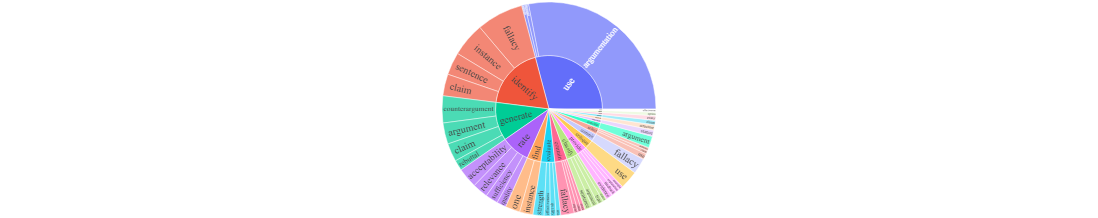

In [45]:
import plotly.express as px

# Filter data
df = df[df["count"] > 30]

# Create sunburst figure
fig = px.sunburst(df, path=['verb', 'noun'], values='count')

# Improve text readability
fig.update_traces(
    insidetextorientation='radial',  # Auto-orient labels for best fit
    textinfo='label',  # Show only category labels (no values)
    marker=dict(line=dict(color='white', width=0.5))  # Add white borders for clarity
)

# Improve layout while keeping size fixed
fig.update_layout(
    autosize=False,
    margin=dict(l=2, r=2, t=2, b=2),  # Minimal margins to maximize usable space
    font=dict(family="Times New Roman", size=10),  # Adjusted font size for small figure
    height=218.26,
    width=218.26
)

# Show figure
fig.show()

# Save as high-quality PDF
fig.write_image(file='verb_noun.pdf', format='pdf', scale=3)

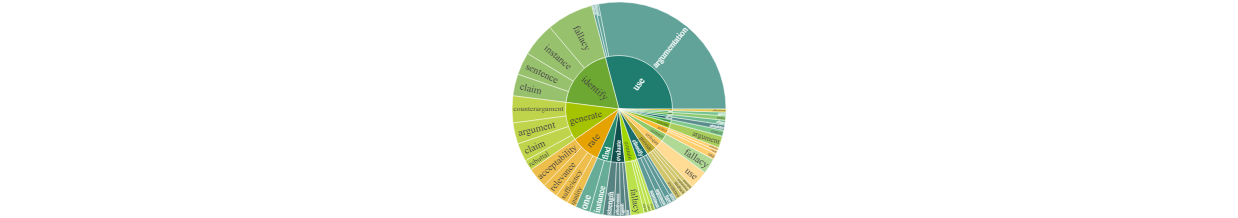

In [53]:
import plotly.express as px

# Filter data
df = df[df["count"] > 30]

#ffd066 (light orange)
#afc96a (yellow-green)
#5ec26e (moderate lime green)

#custom_colors = {
#    'use': '#ffb347', # other
#    'generate': '#ffd066',   # generation
#    'identify': '#5ec26e',  # mining
#    'rate': '#afc96a',  # assessment
#    'evaluate': '#afc96a',  # assessment
#}

# Generate a list of green-yellow shades
color_palette = [
    "#FFAA00",  # Bright Orange
    "#FFBB33",  # Golden Orange
    "#FFCC66",  # Soft Amber
    "#E6A300",  # Deep Yellow-Orange
    "#D4B300",  # Olive Yellow
    "#BFAF30",  # Muted Yellow
    "#A5C300",  # Yellow-Green
    "#8FC96A",  # Soft Yellow-Green
    "#A1D700",  # Vivid Lime Green
    "#85B817",  # Strong Lime
    "#6DA832",  # Earthy Green-Yellow
    "#5EB437",  # Lush Green
    "#49B55A",  # Moderate Green
    "#3AA85F",  # Medium Green
    "#2F9A67",  # Deep Teal-Green
    "#268A6C",  # Forest Green
    "#1F7D6F",  # Dark Green-Teal
    "#196E6B",  # Rich Jungle Green
    "#155F5D",  # Deep Emerald
    "#104F4C"   # Dark Forest Green
]


# Shuffle colors randomly to ensure variation each run
random.shuffle(color_palette)

# Create a dictionary mapping each unique verb to a unique color
unique_verbs = df['verb'].unique()
color_map = {verb: color_palette[i % len(color_palette)] for i, verb in enumerate(unique_verbs)}


# Create sunburst with verb-based coloring
fig = px.sunburst(
    df, 
    path=['verb', 'noun'], 
    values='count',
    color='verb',  # Color by the inner verb
    color_discrete_map=color_map  # Use a diverse color palette
)

# Improve text readability
fig.update_traces(
    insidetextorientation='radial',  # Auto adjust text orientation
    textinfo='label',  # Only show category labels
    marker=dict(line=dict(color='white', width=0.5))  # Add borders for better visibility
)

# Keep original size while improving layout
fig.update_layout(
    autosize=False,
    margin=dict(l=2, r=2, t=2, b=2),  # Minimized margins
    font=dict(family="Times New Roman", size=10),  # Adjusted font size
    height=218.26,
    width=218.26
)

# Show figure
fig.show()

# Save as high-quality PDF
fig.write_image(file='verb_noun.pdf', format='pdf', scale=3)